In [0]:
import torch 
import torchvision
import torch.nn as nn
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

from __future__ import print_function
import os
import random
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.utils as vutils

# Login

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Setup and Training Paramters

## Parameters

In [0]:
# Size of image
image_size = 28

# no of channels
nc = 1

# size of latent space
nz = 128

# no of GPUs
ngpu = 1

# No of filters in the generator and discriminator 
ngf = 64
ndf = 64

# Batch Size
batch_size = 64

# Number of workers
num_workers = 0 # Default in Pytorch

# Enable CUDA if True
cuda = True

# Set Random Seed (set to None if not required)
manual_seed = None

# Learning Rate
lr = 0.0002 # As suggested in the DCGAN paper

# No of epochs
niter = 200

## Load Dataset

In [0]:
# Load MNIST
# Transforms are required to normalize MNIST images
dataset = dset.MNIST(root='../../data/', download=True,
                           transform=transforms.Compose([
                               #transforms.Resize(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,)),
                           ]))

# Create DataLoader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=int(num_workers))

## Enable CUDA

In [0]:
device = torch.device("cuda:0" if cuda else "cpu")
if cuda:
  cudnn.benchmark = True

## Set Random Seed

In [15]:
if manual_seed is None:
    manual_seed = random.randint(1, 10000)
print("Random Seed: ", manual_seed)
random.seed(manual_seed)
torch.manual_seed(manual_seed)

Random Seed:  8619


## Architectures

### Generator

In [0]:
# Following the DCGAN paper guidelines
# No Leaky ReLus in generator
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            
            nn.ConvTranspose2d(nz, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 4 x 4
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 7 x 7
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 14 x 14
            nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 28 x 28
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output

### Discriminator

In [0]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 28 x 28
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 14 x 14
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 7 x 7
            nn.Conv2d(ndf * 2, ndf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
      
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)

## Custom Weight Initialization

In [0]:
# custom weights initialization called on netG and netD
# It is mentioned in Section 4 page 3 to initialize weight with a normal distribution with stdev 0.02
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

netG = Generator(ngpu).to(device)
#netG.apply(weights_init)

netD = Discriminator(ngpu).to(device)
#netD.apply(weights_init)

## Training Parameters

In [0]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)
real_label = 1
fake_label = 0

# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.9, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.9, 0.999))

def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

# Training

[0/200][0/938] Loss_D: 1.4106 Loss_G: 1.2194 D(x): 0.5829 D(G(z)): 0.5666 / 0.3066
[0/200][100/938] Loss_D: 0.0450 Loss_G: 4.2316 D(x): 0.9907 D(G(z)): 0.0347 / 0.0192
[0/200][200/938] Loss_D: 0.0495 Loss_G: 5.7904 D(x): 0.9665 D(G(z)): 0.0132 / 0.0043
[0/200][300/938] Loss_D: 0.0185 Loss_G: 5.9155 D(x): 0.9892 D(G(z)): 0.0075 / 0.0028
[0/200][400/938] Loss_D: 0.0054 Loss_G: 6.1541 D(x): 0.9986 D(G(z)): 0.0040 / 0.0025
[0/200][500/938] Loss_D: 0.0036 Loss_G: 6.8357 D(x): 0.9989 D(G(z)): 0.0026 / 0.0016
[0/200][600/938] Loss_D: 0.0038 Loss_G: 7.4688 D(x): 0.9975 D(G(z)): 0.0012 / 0.0006
[0/200][700/938] Loss_D: 0.0016 Loss_G: 8.8147 D(x): 0.9987 D(G(z)): 0.0003 / 0.0002
[0/200][800/938] Loss_D: 0.0054 Loss_G: 7.5962 D(x): 0.9970 D(G(z)): 0.0024 / 0.0010
[0/200][900/938] Loss_D: 0.0010 Loss_G: 8.8023 D(x): 0.9993 D(G(z)): 0.0003 / 0.0002


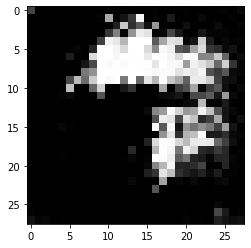

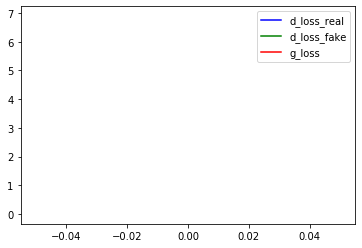

[1/200][0/938] Loss_D: 0.0284 Loss_G: 9.1613 D(x): 0.9919 D(G(z)): 0.0155 / 0.0012
[1/200][100/938] Loss_D: 0.0082 Loss_G: 7.1533 D(x): 0.9952 D(G(z)): 0.0031 / 0.0012
[1/200][200/938] Loss_D: 0.0053 Loss_G: 8.0299 D(x): 0.9977 D(G(z)): 0.0030 / 0.0015
[1/200][300/938] Loss_D: 0.0715 Loss_G: 9.3760 D(x): 0.9505 D(G(z)): 0.0004 / 0.0002
[1/200][400/938] Loss_D: 0.0346 Loss_G: 6.7558 D(x): 0.9991 D(G(z)): 0.0276 / 0.0051
[1/200][500/938] Loss_D: 0.0074 Loss_G: 7.1988 D(x): 0.9944 D(G(z)): 0.0017 / 0.0016
[1/200][600/938] Loss_D: 0.0185 Loss_G: 7.6987 D(x): 0.9932 D(G(z)): 0.0104 / 0.0018
[1/200][700/938] Loss_D: 0.0108 Loss_G: 8.8456 D(x): 0.9987 D(G(z)): 0.0085 / 0.0021
[1/200][800/938] Loss_D: 0.1405 Loss_G: 8.4461 D(x): 0.9075 D(G(z)): 0.0075 / 0.0036
[1/200][900/938] Loss_D: 0.1882 Loss_G: 4.8822 D(x): 0.9542 D(G(z)): 0.0811 / 0.0425


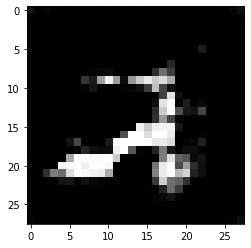

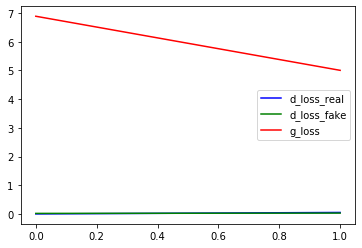

[2/200][0/938] Loss_D: 0.0423 Loss_G: 6.3334 D(x): 0.9770 D(G(z)): 0.0163 / 0.0071
[2/200][100/938] Loss_D: 0.1985 Loss_G: 11.6917 D(x): 0.8434 D(G(z)): 0.0003 / 0.0001
[2/200][200/938] Loss_D: 0.2124 Loss_G: 8.4991 D(x): 0.8391 D(G(z)): 0.0006 / 0.0007
[2/200][300/938] Loss_D: 0.0668 Loss_G: 6.9531 D(x): 0.9510 D(G(z)): 0.0084 / 0.0032
[2/200][400/938] Loss_D: 0.0988 Loss_G: 5.4945 D(x): 0.9714 D(G(z)): 0.0591 / 0.0134
[2/200][500/938] Loss_D: 0.0616 Loss_G: 6.3208 D(x): 0.9603 D(G(z)): 0.0174 / 0.0077
[2/200][600/938] Loss_D: 0.2094 Loss_G: 5.0173 D(x): 0.9178 D(G(z)): 0.0752 / 0.0387
[2/200][700/938] Loss_D: 0.1994 Loss_G: 3.6369 D(x): 0.9507 D(G(z)): 0.1057 / 0.0707
[2/200][800/938] Loss_D: 0.1621 Loss_G: 5.4171 D(x): 0.9269 D(G(z)): 0.0475 / 0.0230
[2/200][900/938] Loss_D: 0.2295 Loss_G: 3.5544 D(x): 0.9517 D(G(z)): 0.1272 / 0.0972


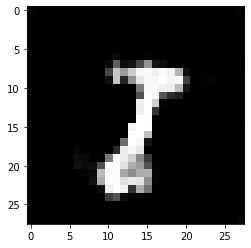

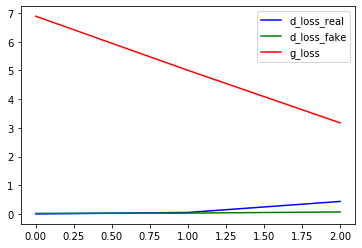

[3/200][0/938] Loss_D: 0.2317 Loss_G: 2.9082 D(x): 0.9784 D(G(z)): 0.1483 / 0.1179
[3/200][100/938] Loss_D: 0.4889 Loss_G: 3.3773 D(x): 0.8805 D(G(z)): 0.1909 / 0.1064
[3/200][200/938] Loss_D: 0.1906 Loss_G: 4.9070 D(x): 0.8981 D(G(z)): 0.0509 / 0.0239
[3/200][300/938] Loss_D: 0.1083 Loss_G: 5.6653 D(x): 0.9102 D(G(z)): 0.0063 / 0.0087
[3/200][400/938] Loss_D: 0.1511 Loss_G: 3.3183 D(x): 0.9532 D(G(z)): 0.0868 / 0.0762
[3/200][500/938] Loss_D: 0.1924 Loss_G: 3.4688 D(x): 0.9564 D(G(z)): 0.1222 / 0.0537
[3/200][600/938] Loss_D: 0.1640 Loss_G: 7.9017 D(x): 0.8856 D(G(z)): 0.0228 / 0.0019
[3/200][700/938] Loss_D: 0.3311 Loss_G: 5.1960 D(x): 0.8150 D(G(z)): 0.0739 / 0.0213
[3/200][800/938] Loss_D: 0.2446 Loss_G: 3.6871 D(x): 0.8660 D(G(z)): 0.0693 / 0.0596
[3/200][900/938] Loss_D: 0.2369 Loss_G: 3.4133 D(x): 0.9186 D(G(z)): 0.1148 / 0.0841


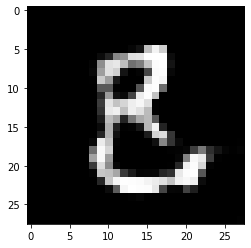

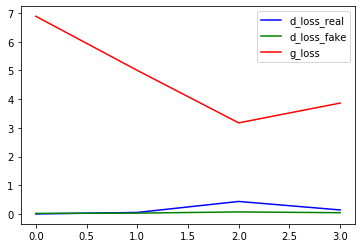

[4/200][0/938] Loss_D: 0.1403 Loss_G: 3.2538 D(x): 0.9583 D(G(z)): 0.0854 / 0.0671
[4/200][100/938] Loss_D: 0.3220 Loss_G: 5.2011 D(x): 0.7695 D(G(z)): 0.0166 / 0.0184
[4/200][200/938] Loss_D: 0.1793 Loss_G: 3.3324 D(x): 0.9549 D(G(z)): 0.1092 / 0.0729
[4/200][300/938] Loss_D: 0.1611 Loss_G: 4.0276 D(x): 0.9829 D(G(z)): 0.1141 / 0.0530
[4/200][400/938] Loss_D: 0.1776 Loss_G: 3.1071 D(x): 0.9598 D(G(z)): 0.1034 / 0.1049
[4/200][500/938] Loss_D: 0.1159 Loss_G: 4.2783 D(x): 0.9596 D(G(z)): 0.0630 / 0.0298
[4/200][600/938] Loss_D: 0.1996 Loss_G: 3.6391 D(x): 0.8865 D(G(z)): 0.0604 / 0.0503
[4/200][700/938] Loss_D: 0.1461 Loss_G: 4.8784 D(x): 0.8992 D(G(z)): 0.0232 / 0.0276
[4/200][800/938] Loss_D: 0.1725 Loss_G: 4.1826 D(x): 0.9049 D(G(z)): 0.0558 / 0.0309
[4/200][900/938] Loss_D: 0.2384 Loss_G: 2.6646 D(x): 0.9399 D(G(z)): 0.1314 / 0.1349


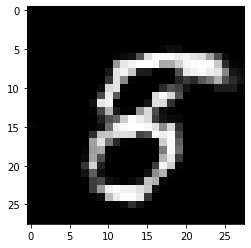

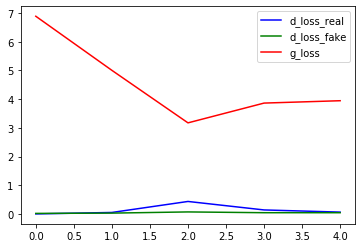

[5/200][0/938] Loss_D: 0.1381 Loss_G: 3.9001 D(x): 0.9233 D(G(z)): 0.0452 / 0.0520
[5/200][100/938] Loss_D: 0.1488 Loss_G: 3.7239 D(x): 0.9916 D(G(z)): 0.1176 / 0.0450
[5/200][200/938] Loss_D: 0.3466 Loss_G: 3.2674 D(x): 0.7752 D(G(z)): 0.0441 / 0.0674
[5/200][300/938] Loss_D: 0.2224 Loss_G: 3.1985 D(x): 0.9599 D(G(z)): 0.1505 / 0.0732
[5/200][400/938] Loss_D: 0.7092 Loss_G: 2.8000 D(x): 0.9794 D(G(z)): 0.3917 / 0.1213
[5/200][500/938] Loss_D: 0.2097 Loss_G: 3.8143 D(x): 0.8619 D(G(z)): 0.0393 / 0.0492
[5/200][600/938] Loss_D: 0.2137 Loss_G: 4.0079 D(x): 0.9716 D(G(z)): 0.1240 / 0.0570
[5/200][700/938] Loss_D: 0.1138 Loss_G: 3.8035 D(x): 0.9426 D(G(z)): 0.0419 / 0.0473
[5/200][800/938] Loss_D: 0.5325 Loss_G: 2.1594 D(x): 0.9916 D(G(z)): 0.3452 / 0.1743
[5/200][900/938] Loss_D: 0.1389 Loss_G: 3.4320 D(x): 0.9600 D(G(z)): 0.0848 / 0.0635


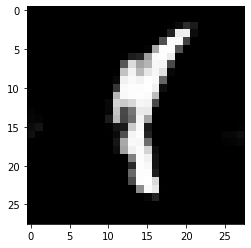

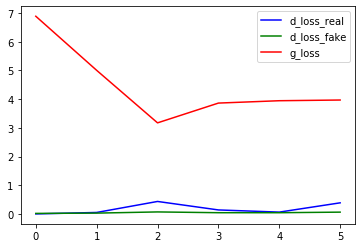

[6/200][0/938] Loss_D: 0.7154 Loss_G: 2.4414 D(x): 0.6009 D(G(z)): 0.0757 / 0.1688
[6/200][100/938] Loss_D: 0.2489 Loss_G: 5.7799 D(x): 0.8282 D(G(z)): 0.0313 / 0.0068
[6/200][200/938] Loss_D: 0.1982 Loss_G: 3.5140 D(x): 0.9556 D(G(z)): 0.1291 / 0.0498
[6/200][300/938] Loss_D: 0.3020 Loss_G: 2.5672 D(x): 0.8098 D(G(z)): 0.0539 / 0.1393
[6/200][400/938] Loss_D: 0.4145 Loss_G: 4.6557 D(x): 0.7405 D(G(z)): 0.0059 / 0.0197
[6/200][500/938] Loss_D: 0.3432 Loss_G: 2.0259 D(x): 0.9686 D(G(z)): 0.2324 / 0.2007
[6/200][600/938] Loss_D: 0.2248 Loss_G: 3.3673 D(x): 0.9140 D(G(z)): 0.1029 / 0.0636
[6/200][700/938] Loss_D: 0.1211 Loss_G: 2.7134 D(x): 0.9590 D(G(z)): 0.0689 / 0.1353
[6/200][800/938] Loss_D: 0.2309 Loss_G: 3.4836 D(x): 0.8979 D(G(z)): 0.0796 / 0.0565
[6/200][900/938] Loss_D: 0.2341 Loss_G: 2.9996 D(x): 0.9300 D(G(z)): 0.1320 / 0.0783


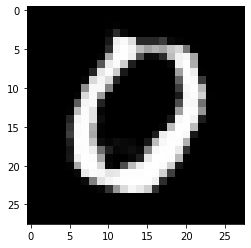

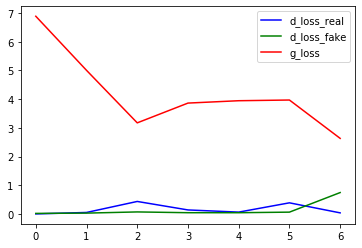

[7/200][0/938] Loss_D: 0.5441 Loss_G: 3.5135 D(x): 0.7255 D(G(z)): 0.1369 / 0.0604
[7/200][100/938] Loss_D: 0.1509 Loss_G: 4.4661 D(x): 0.9327 D(G(z)): 0.0658 / 0.0266
[7/200][200/938] Loss_D: 0.2310 Loss_G: 3.2300 D(x): 0.9112 D(G(z)): 0.1063 / 0.0934
[7/200][300/938] Loss_D: 0.1472 Loss_G: 3.3163 D(x): 0.9399 D(G(z)): 0.0754 / 0.0677
[7/200][400/938] Loss_D: 0.5115 Loss_G: 2.7888 D(x): 0.9541 D(G(z)): 0.3108 / 0.1122
[7/200][500/938] Loss_D: 0.2270 Loss_G: 3.1976 D(x): 0.9621 D(G(z)): 0.1449 / 0.0897
[7/200][600/938] Loss_D: 0.3656 Loss_G: 4.1074 D(x): 0.7490 D(G(z)): 0.0220 / 0.0428
[7/200][700/938] Loss_D: 0.6044 Loss_G: 2.8520 D(x): 0.6323 D(G(z)): 0.0522 / 0.1209
[7/200][800/938] Loss_D: 0.1606 Loss_G: 4.6107 D(x): 0.8976 D(G(z)): 0.0435 / 0.0201
[7/200][900/938] Loss_D: 0.2302 Loss_G: 3.8152 D(x): 0.8946 D(G(z)): 0.0904 / 0.0449


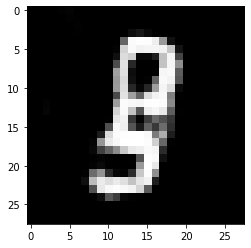

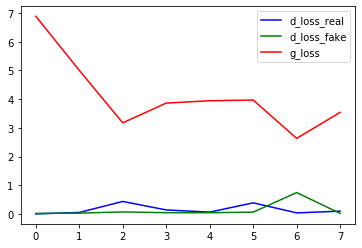

[8/200][0/938] Loss_D: 0.1389 Loss_G: 2.8920 D(x): 0.9435 D(G(z)): 0.0684 / 0.1104
[8/200][100/938] Loss_D: 0.3891 Loss_G: 4.7598 D(x): 0.7271 D(G(z)): 0.0142 / 0.0194
[8/200][200/938] Loss_D: 0.1028 Loss_G: 5.9060 D(x): 0.9464 D(G(z)): 0.0404 / 0.0088
[8/200][300/938] Loss_D: 0.4202 Loss_G: 3.1750 D(x): 0.9378 D(G(z)): 0.2450 / 0.0901
[8/200][400/938] Loss_D: 0.1561 Loss_G: 3.1442 D(x): 0.9553 D(G(z)): 0.0934 / 0.0887
[8/200][500/938] Loss_D: 0.4450 Loss_G: 3.1567 D(x): 0.7540 D(G(z)): 0.0825 / 0.0757
[8/200][600/938] Loss_D: 0.2760 Loss_G: 2.4752 D(x): 0.9083 D(G(z)): 0.1354 / 0.1681
[8/200][700/938] Loss_D: 0.2082 Loss_G: 2.3629 D(x): 0.9797 D(G(z)): 0.1422 / 0.1658
[8/200][800/938] Loss_D: 0.1892 Loss_G: 4.9274 D(x): 0.8781 D(G(z)): 0.0416 / 0.0216
[8/200][900/938] Loss_D: 0.3867 Loss_G: 1.7285 D(x): 0.9655 D(G(z)): 0.2491 / 0.2630


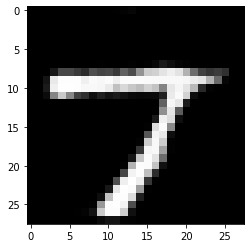

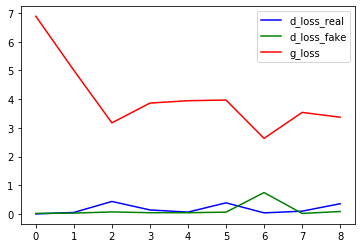

[9/200][0/938] Loss_D: 0.6102 Loss_G: 3.1192 D(x): 0.6497 D(G(z)): 0.0480 / 0.0942
[9/200][100/938] Loss_D: 0.2470 Loss_G: 4.0309 D(x): 0.8648 D(G(z)): 0.0730 / 0.0364
[9/200][200/938] Loss_D: 0.3906 Loss_G: 2.3428 D(x): 0.8624 D(G(z)): 0.1634 / 0.1695
[9/200][300/938] Loss_D: 0.1822 Loss_G: 4.5633 D(x): 0.8764 D(G(z)): 0.0296 / 0.0337
[9/200][400/938] Loss_D: 0.2481 Loss_G: 2.1720 D(x): 0.9555 D(G(z)): 0.1593 / 0.1833
[9/200][500/938] Loss_D: 0.3658 Loss_G: 3.6225 D(x): 0.8441 D(G(z)): 0.1393 / 0.0589
[9/200][600/938] Loss_D: 0.5947 Loss_G: 2.5922 D(x): 0.9624 D(G(z)): 0.3500 / 0.1256
[9/200][700/938] Loss_D: 0.4414 Loss_G: 2.2217 D(x): 0.9672 D(G(z)): 0.2777 / 0.1829
[9/200][800/938] Loss_D: 0.2591 Loss_G: 3.6059 D(x): 0.8755 D(G(z)): 0.1022 / 0.0523
[9/200][900/938] Loss_D: 0.3632 Loss_G: 2.9981 D(x): 0.9422 D(G(z)): 0.2223 / 0.0935


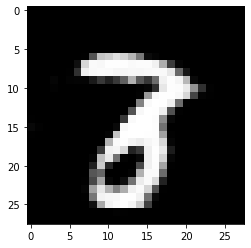

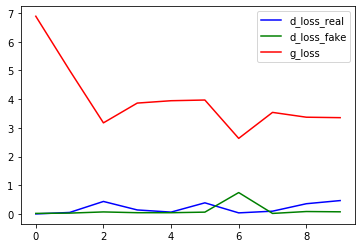

[10/200][0/938] Loss_D: 0.3450 Loss_G: 2.7307 D(x): 0.7841 D(G(z)): 0.0636 / 0.1216
[10/200][100/938] Loss_D: 0.3769 Loss_G: 2.2866 D(x): 0.9059 D(G(z)): 0.1911 / 0.1729
[10/200][200/938] Loss_D: 0.1589 Loss_G: 3.8332 D(x): 0.9384 D(G(z)): 0.0766 / 0.0458
[10/200][300/938] Loss_D: 0.1604 Loss_G: 4.6871 D(x): 0.9089 D(G(z)): 0.0475 / 0.0286
[10/200][400/938] Loss_D: 0.4469 Loss_G: 2.5433 D(x): 0.7422 D(G(z)): 0.0723 / 0.1484
[10/200][500/938] Loss_D: 1.3546 Loss_G: 4.5070 D(x): 0.3541 D(G(z)): 0.0106 / 0.0307
[10/200][600/938] Loss_D: 0.1431 Loss_G: 3.8229 D(x): 0.9365 D(G(z)): 0.0621 / 0.0419
[10/200][700/938] Loss_D: 0.2500 Loss_G: 2.9334 D(x): 0.9250 D(G(z)): 0.1322 / 0.1072
[10/200][800/938] Loss_D: 0.2606 Loss_G: 3.4922 D(x): 0.8340 D(G(z)): 0.0475 / 0.0607
[10/200][900/938] Loss_D: 0.3574 Loss_G: 3.2359 D(x): 0.7714 D(G(z)): 0.0518 / 0.0765


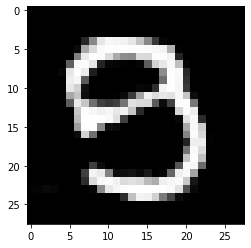

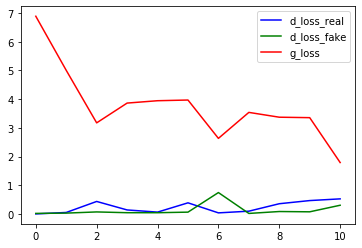

[11/200][0/938] Loss_D: 0.4423 Loss_G: 1.7698 D(x): 0.8741 D(G(z)): 0.2218 / 0.2464
[11/200][100/938] Loss_D: 0.2268 Loss_G: 3.3529 D(x): 0.9824 D(G(z)): 0.1618 / 0.0666
[11/200][200/938] Loss_D: 0.2088 Loss_G: 3.4266 D(x): 0.9564 D(G(z)): 0.1331 / 0.0627
[11/200][300/938] Loss_D: 0.6452 Loss_G: 1.6136 D(x): 0.9532 D(G(z)): 0.3713 / 0.2843
[11/200][400/938] Loss_D: 0.1763 Loss_G: 4.1200 D(x): 0.8804 D(G(z)): 0.0294 / 0.0389


In [0]:
g_loss_list = []
epoch_list = []
d_loss_real_list = []
d_loss_fake_list = []
for epoch in range(niter):
    epoch_list.append(epoch)
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_img = data[0].to(device)
        batch_size = real_img.size(0)
        label = torch.full((batch_size,), real_label, device=device)
        output = netD(real_img)
        errD_real = criterion(output, label)

        if i == len(dataloader) - 1:
          d_loss_real_list.append(errD_real)

        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        noise = noise.view(batch_size, nz, 1, -1)
        fake = netG(noise)

        label.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()

        if i == len(dataloader) - 1:
          d_loss_fake_list.append(errD_fake)

        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()

        if i == len(dataloader) - 1:
          g_loss_list.append(errG)
        
        D_G_z2 = output.mean().item()
        optimizerG.step()

        if i % 100 == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, niter, i, len(dataloader),
                 errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
    
    # Draw Sampled Images
    fake_images_clone = fake.clone()
    im = denorm(fake_images_clone[0]).cpu().detach().numpy()
    im = (im * 255).astype(np.uint8)
    im = im.reshape((28, 28))
    imgplot = plt.imshow(im, cmap='gray')
    plt.show()

    plt.plot(epoch_list, d_loss_real_list, 'b-', label = 'd_loss_real')
    plt.plot(epoch_list, d_loss_fake_list, 'g-', label = 'd_loss_fake') 
    plt.plot(epoch_list, g_loss_list, 'r-', label = 'g_loss')
    plt.legend()
    plt.show()
        

    # do checkpointing
    #torch.save(netG.state_dict(), '%s/netG_epoch_%d.pth' % (opt.outf, epoch))
    #torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (opt.outf, epoch))

# Setup and Train Auxiliary Classifier

## Data Augmentation

In [0]:
# Device setting
netD = netD.to(device)
netG = netG.to(device)

# Create an equal number of fake images
aug_size = len(dataset)
z = torch.randn(aug_size, nz).to(device)
fake_dataset_images = netG(z)
fake_dataset_labels = torch.zeros(aug_size, 1)
fake_dataset = (fake_dataset_images.clone().cpu().detach(), fake_dataset_labels.clone().cpu().detach())

# Ugly code to pry out data from an existing dataset
original_data = np.zeros((len(dataset), 1, image_size, image_size))
for i in range(len(dataset)):
  original_data[i,:] = dataset[i][0]


## Create Classifier

In [76]:
# Fully connected neural network with the same architecture as the Discriminator
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 28 x 28
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 14 x 14
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 7 x 7
            nn.Conv2d(ndf * 2, ndf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, ndf * 8, 4, 1, 0, bias=False),
            #nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 1 x 1
            nn.Conv2d(ndf * 8, 1, 1, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.main(input)

        return output.view(-1, 1).squeeze(1)

clf = Classifier().to(device)
clf.apply(weights_init)

Classifier(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Conv2d(512, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (11): Sigmoid()
  )
)

## Train Classifier

In [0]:
# Train the model
num_epochs_clf = 1
total_step = len(train_loader)
for epoch in range(num_epochs_clf):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.reshape(batch_size, -1).to(device)
        #images = images.reshape(-1, 28*28).to(device)
        labels = labels.reshape(batch_size, -1).to(device)
        
        # Forward pass
        outputs = clf(images.float())
        loss = clf.criterion(outputs, labels.float())
        
        # Backward and optimize
        clf.optimizer.zero_grad()
        loss.backward()
        clf.optimizer.step()

        if i == 300:
          break
        
        if (i+1) % 500 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs_clf, i+1, total_step, loss.item()))

## Test Classifier

In [0]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
clf = D
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(batch_size, -1).to(device)
        #images = images.reshape(-1, 28*28).to(device)
        labels = labels.reshape(batch_size, -1).to(device)

        outputs = clf(images.float())
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        predicted_labels = torch.where(outputs > 0.5, real_labels, fake_labels)


        total += labels.size(0)
        correct += (predicted_labels == labels).sum().item()

    print('Accuracy of the network on the {} test images: {} %'.format(total, 100 * correct / total))